# Mission 4 - Terraforming other worlds.....

Part of the Baskerville's five year mission will be to discover lifeless worlds and make them fit for human habitation. This will be a difficult task but one that any potential Baskerville crew should sail through. 

Part of terraforming a distant world is to create a stable ecosystem with a sustainable balance of plants, plant eaters and predators. We need you to develop an agent-based model of the interactions between these to set up stable initial conditions for our ecosystem. Agent-based modelling comes into its own once the number of different types of agents, and the complexity of their behaviors, becomes too much for conventional branches of mathematics such as the [Lotka-Voltera equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations). This type of model is a general paradigm used for expected areas such as disease and economic simulations, but also things like crowd control. These models set the rate of change of a type (e.g. species population, size of army) equal to the sum of each type multiplied by a constant. Solving these leads to an Eigenvalue problem.

We're going to be using a library called [FLAME GPU 2](https://github.com/FLAMEGPU/FLAMEGPU2), written by Dr. Paul Richmond from the University of Sheffield. This allows agent-based modeling to take advantage of GPUs to speed up the calculations.

## First steps

To start the Challenge, you'll need to return to what you learnt in Challenge 1 yesterday morning as we're going to need to load two modules. First start by opening a portal window Captain Yearwood has helpfully built the Flames Python module so that it's compatible with Baskerville. You'll also need matplotlib so you can see how your ecosystem is doing. The screenshots below demonstrate this,

### Starting the Portal - [portal.baskerville.ac.uk](portal.baskerville.ac.uk)
![Starting the Portal](images/StartPortalSession.png)

### Loading the Flames GPU Module
![Loading the Flames GPU Module](images/LoadFlamesModule.png)

### Loading the Matplotlib Module
![Loading the Matplotlib Module](images/LoadMatplotlib.png)

Don't forget to restart your kernel after loading the modules.

This worksheet contains a lot of big cells so remember that you can collapse the cells using the blue line on the left of the cell.

## Getting Started

Lets start by importing the libraries so that we know everything works.

In [1]:
import pyflamegpu
import sys, random, math
import matplotlib.pyplot as plt 

Let's include a line to make matplotlib work with Jupyter Lab

In [2]:
%matplotlib inline

## The Predator-Prey Model

Predator-prey models capture the dynamic behaviour of competing species within an environment to demonstrate population dynamics as species try to survive. The model is important as it captures emergent macro-level phenomena which can be observed within other domains such as economics.

In its most basic form, a two-species system consists of both prey and predators, we'll add a third agent as part of this Challenge. Put simply, Prey reproduce but are eaten by predators and predators reproduce and eat prey. Typically such systems can be represented using non-linear differential equations known as Lotka-Volterra equations. In a more advanced form of the model, microscopic behaviours of the species can be considered by using agent-based representation. E.g. The predators can have energy which is depleted as they move. Prey can form cohesive groups (flocking) and dynamically avoid predators, while predators can move towards prey. If a predator and prey are close enough (i.e. within a fixed kill radius), the predator is able to eat the prey and increase the amount of energy it has. Predators die when they run out of energy.

The model has been implemented in various Agen-Based Modelling frameworks (e.g. NetLogo and FLAME). The tutorial model implements the following behaviours for one or both of the types of agent:

+ Predator and Prey agents move and act in a sequence of iterations (time steps).
+ Predator and Prey agents have real-valued (x, y) positions and velocities which are integrated over time.
+ Predator agents have an initial velocity. A Predator adjusts its velocity to follow the nearest prey within a synthetic limited vision.
+ A predator’s energy is reduced by 1 unit of energy each time it moves.
+ Prey are eaten by the closest predator agent within a fixed (kill) radius.
  -  A predator’s energy increases each time it catches a prey.
  -  A predator dies if it has run out of energy.

More specific details of the model features are described below.

Prey catching There is no limit on the amount of prey a predator can eat per iteration. If a predator is close to multiple prey within the specific (kill) radius, the predator will kill/eat them all. A prey cannot be shared between multiple predators. If there are multiple predators within the kill radius then only the closest will eat the prey.

Reproduction Each species has a rate of reproduction. When an agent reproduces, the parent’s energy is shared evenly between parent and child, so both will have half of the parent’s energy for the next iteration.

                                                                                                                                                                                            
## FLAME GPU 2 Implementation

The FLAME GPU 2 implementation of the predator-prey model is based on the assumptions made in the previous section. 
+ All agents have a real-valued position (x, y) within a continuous environment. 
+ The environment bounds are wrapped to form a continuous toroidal space in which agents can move; think asteroids. 
+ Agents have a velocity (vx and vy) in which they will move and a steering velocity (steer_x and steer_y) which dictates how they should adjust their velocity according to local interactions. 
+ Predator agents have a variable (life) that contains their level of energy. 
+ An agent variable, type, is used for visualisations of the simulation where unique type values correspond to different colours within the visualisation. The type is set by the initial values of the agent and does not change over time.

Each agent has a unique identifier variable (id). When a predator kills a prey, it is necessary to communicate identifiers to ensure correct behaviour as will be explained later in this section.

All communication between agents in FLAME GPU 2 is performed indirectly via messages. In this model, we have three message types which are required to perform the mechanism for killing. E.g,

+ Both prey and predators output their (x, y) coordinates to a prey or predator location message respectively.
+ Prey read predator locations and perform evasive behaviour to avoid them.
+ Predators read prey locations and move toward the closest visible prey.
+ Prey read each other's location and move towards each other to form cohesive groups.
+ Both predators and prey read their own species' locations to avoid each other when in close proximity.
+ Prey read the locations of predators and calculate the nearest predator within the kill distance. If a predator is within the kill distance then it notifies this predator by sending a prey_eaten_message message with the predator's id and the eaten prey dies (is removed for the simulation).
+ Predators read the prey_eaten_message messages and check them to see if their id has been communicated by any dead prey. If the message indicates that the predator ate some prey, then the predator increases its energy/life accordingly.

                                                                        

## The FLAME GPU 2 Model

A FLAME GPU 2 model specification consists of: 

+ an environment that holds global information related to the simulation such as constant variables and behaviour script file names
+ agents which describe use variables and functions to describe the properties and behaviours of individuals in the simulation
+ messages which represent information communicated between agents. Each aspect is introduced in the following subsections with examples. 

In the python build of FLAME GPU 2, all of these model elements are described through the python interface. A ModelDescription object acts as a container for the various components which make up the model. The name isn't important

The following sections will describe how to create each of the above components and attach them to the ModelDescription. Each code cell defines a particular function. By defining functions rather than running the code directly, they can be updated individually and defined out of order. 

These functions are then all called in the correct order in the run simulation cell later in the document.

## 1.) Create a model

The ModelDescription object is created with the name "Terraforming Environment". We use this as a holder to contain all the functions Individual functions are used to wrap the creation of each of the various elements of the model.

In [3]:
def create_model():
    model = pyflamegpu.ModelDescription("python-tutorial")
    return model

### 2.) Define Environmental Constants

Given the model, we can get it's environment and use this to set all the constants for this version of the model. These can also be read from a file and means there's no recompilation if you're using the C++ version.

In [11]:
def define_environment(model):
    """
        Environment
    """
    env = model.Environment()

    # Reproduction
    env.newPropertyFloat("REPRODUCE_PREY_PROB", 0.05)
    env.newPropertyFloat("REPRODUCE_PRED_PROB", 0.03)

    # Cohesion/Avoidance
    env.newPropertyFloat("SAME_SPECIES_AVOIDANCE_RADIUS", 0.035)
    env.newPropertyFloat("PREY_GROUP_COHESION_RADIUS", 0.2)

    # Predator/Prey/Grass interaction
    env.newPropertyFloat("PRED_PREY_INTERACTION_RADIUS", 0.3)
    env.newPropertyFloat("PRED_SPEED_ADVANTAGE", 3.0)
    env.newPropertyFloat("PRED_KILL_DISTANCE", 0.05)
    env.newPropertyFloat("GRASS_EAT_DISTANCE", 0.02)
    env.newPropertyUInt("GAIN_FROM_FOOD_PREY", 80)
    env.newPropertyUInt("GAIN_FROM_FOOD_PREDATOR", 50)
    env.newPropertyUInt("GRASS_REGROW_CYCLES", 100)
    
    # Simulation properties
    env.newPropertyFloat("DELTA_TIME", 0.001)
    env.newPropertyFloat("BOUNDS_WIDTH", 2.0)
    env.newPropertyFloat("MIN_POSITION", -1.0)
    env.newPropertyFloat("MAX_POSITION", 1.0)

## 3.) Define Messages

Messages are simple collections of variables that are used to communicate data between agents. Messages are defined in the same way as the environment variables and agents.

### Spatial Partitioning Schemes 

It can get very expensive to send messages from every agent to every other agent, although this is what we do in this challenge by creating them using the newMessageBruteForce method. However, there are other spatial partitioning schemes that may offer increased efficiency. These schemes improve computation time by limiting the messages each agent sees to those which are nearby, with schemes for 2 and 3-D, reducing the computational complexity from O(n^2). 

The code below shows the definition of a brute force message which can be used to communicate the location of a prey agent:


In [12]:
def define_messages(model):
    """
      Location messages
    """      
    message = model.newMessageBruteForce("predator_location_message")
    message.newVariableID("id")
    message.newVariableFloat("x")
    message.newVariableFloat("y")
        
    message = model.newMessageBruteForce("prey_location_message")
    message.newVariableID("id")
    message.newVariableFloat("x")
    message.newVariableFloat("y")

    """
      Agent eaten messages
    """
        
    message = model.newMessageBruteForce("prey_eaten_message")
    message.newVariableID("id")
    message.newVariableInt("pred_id")

    message = model.newMessageBruteForce("grass_eaten_message")
    message.newVariableID("id")
    message.newVariableInt("prey_id")

## 4.) Define Agents - Finally....

**Agent Variables**

Agents represent individuals in the simulation and are defined using an `AgentDescription`. Much like the environment, we ask the model to provide us with a reference to the new agent which we can then add variables to. As with the environment, each variable is given a type and a name.

**Specifying Agent Functions**

Agent functions are used to implement agent behaviours. The tables below give the functions of the predators and prey and their roles.

| Prey Function | Description |
|:---|:---|
|prey_output_location | each prey agent outputs information to be read by other agents|
|prey_avoid_pred |	prey agents avoiding predator agents|
|prey_flock | flocking between prey agents|
|prey_move | movement of prey agents|
|prey_eaten | prey agents get killed by predator agents|
|prey_reproduction | regeneration of prey|


| Predator Function | Description |
|:---|:---|
|pred_output_location | each predator agent outputs information to be read by other agents|
|pred_follow_prey | predator agents follow prey agents|
|pred_avoid | predator agents avoid each other|
|pred_move | movement of predator agents|
|pred_eat_or_starve | predator agents gain energy or starve|
|prey_reproduction | regeneration of predators|

Functions can be applied to agents in a specified *initial_state* and can optionally cause agents to move to other *states*. As our model is relatively simple, we only use a single default state. Furthermore, functions can have *conditions*. For example, a function that simulates agent death might check a variable incremented each iteration called life-cycles to see if it has reached a maximum number. Only agents meeting this condition would perform the behaviour and move into a dead state. The predator-prey model is a stateless model (each agent has only a single state) as functions do not require any function conditions. 

Functions can have at most one input and one output. Inputs and outputs are in the form of messages which, are a collection of variables which are persistent until the end of the simulation iteration (at which point they are destroyed). A function description within a model requires that any inputs or outputs are fully specified.

The descriptions of the predator, prey and grass agents' variables and functions in FLAME GPU 2 are given below:

In [13]:
def define_agents(model):
    """
        Prey agent
    """
    # Create the agent
    agent = model.newAgent("prey")

    # Assign its variables
    agent.newVariableFloat("x")
    agent.newVariableFloat("y")
    agent.newVariableFloat("vx")
    agent.newVariableFloat("vy")
    agent.newVariableFloat("steer_x")
    agent.newVariableFloat("steer_y")
    agent.newVariableInt("life")
    agent.newVariableFloat("type")
    
    # Assign its functions
    fn = agent.newRTCFunction("prey_output_location", prey_output_location)
    fn.setMessageOutput("prey_location_message")

    fn = agent.newRTCFunction("prey_avoid_pred", prey_avoid_pred)
    fn.setMessageInput("predator_location_message")

    fn = agent.newRTCFunction("prey_flock", prey_flock)
    fn.setMessageInput("prey_location_message")

    fn = agent.newRTCFunction("prey_move", prey_move)

    fn = agent.newRTCFunction("prey_eaten", prey_eaten)
    fn.setMessageInput("predator_location_message")
    fn.setMessageOutput("prey_eaten_message")
    fn.setMessageOutputOptional(True)
    fn.setAllowAgentDeath(True)

    #fn = agent.newRTCFunction("prey_eat_or_starve", prey_eat_or_starve)
    #fn.setMessageInput("grass_eaten_message")
    #fn.setAllowAgentDeath(True)
    
    fn = agent.newRTCFunction("prey_reproduction", prey_reproduction)
    fn.setAgentOutput("prey", "default")
    
    """
      Predator agent
    """
    # Create the agent
    agent = model.newAgent("predator")

    # Assign its variables
    agent.newVariableFloat("x")
    agent.newVariableFloat("y")
    agent.newVariableFloat("vx")
    agent.newVariableFloat("vy")
    agent.newVariableFloat("steer_x")
    agent.newVariableFloat("steer_y")
    agent.newVariableInt("life")
    agent.newVariableFloat("type")
    
    # Assign its functions
    fn = agent.newRTCFunction("pred_output_location", pred_output_location)
    fn.setMessageOutput("predator_location_message")
    fn = agent.newRTCFunction("pred_follow_prey", pred_follow_prey)
    fn.setMessageInput("prey_location_message")
    fn = agent.newRTCFunction("pred_avoid", pred_avoid)
    fn.setMessageInput("predator_location_message")
    fn = agent.newRTCFunction("pred_move", pred_move)
    fn = agent.newRTCFunction("pred_eat_or_starve", pred_eat_or_starve)
    fn.setMessageInput("prey_eaten_message")
    fn.setAllowAgentDeath(True)
    fn = agent.newRTCFunction("pred_reproduction", pred_reproduction)
    fn.setAgentOutput("predator", "default")
    
    """
        Grass agent
    """
    # Create the agent
    
    # Assign its functions


## 5.) Defining Agent Functions

The agent function behaviours must be defined using a small subset of the CUDA C++ programming language. Don't panic, a brief summary of the language is given below:

| Action | Code format |
| :--- | :--- |
| Write a comment | `// This will be a comment` |
| Declare a variable | `type variable_name = value;` |
| Declare a constant | `const type variable_name = value;` |
| Get the value of an environment property| `FLAMEGPU->environment.getProperty<type>("property_name");` |
| Iterate & access input messages | `for (const auto& msg :  FLAMEGPU->message_in) { ` <br>&nbsp;&nbsp; `// Each message is now accessible inside this loop via msg` <br> `}`
| Read an input message variable value | `msg.getVariable<type>("variable_name");` |
| Set an output message variable value | `FLAMEGPU->message_out.setVariable<type>("variable_name", value_to_set_variable_to);` |
| Generate a random float in the range [0,1) | `FLAMEGPU->random.uniform<float>()` |
| Function leaves agent alive | `return flamegpu::ALIVE` |
| Function kills agent | `return flamegpu::DEAD` |

It is not important to read every single agent function definition below, just try to familiarise yourself with their structure a bit as we will be writing some of these later in the tutorial!

Read down to the bottom to see the Python population tracker class.

In [14]:
"""
  outputdata agent function for Boid agents, which outputs publicly visible properties to a message list
"""
pred_output_location = r"""
FLAMEGPU_AGENT_FUNCTION(pred_output_location, flamegpu::MessageNone, flamegpu::MessageBruteForce) {
    const flamegpu::id_t id = FLAMEGPU->getID();
    const float x = FLAMEGPU->getVariable<float>("x");
    const float y = FLAMEGPU->getVariable<float>("y");
    FLAMEGPU->message_out.setVariable<int>("id", id);
    FLAMEGPU->message_out.setVariable<float>("x", x);
    FLAMEGPU->message_out.setVariable<float>("y", y);

    return flamegpu::ALIVE;
}
"""

"""
  inputdata agent function for Boid agents, which reads data from neighbouring Boid agents, to perform the boid flocking model.
"""
pred_follow_prey = r"""
FLAMEGPU_AGENT_FUNCTION(pred_follow_prey, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    const float PRED_PREY_INTERACTION_RADIUS = FLAMEGPU->environment.getProperty<float>("PRED_PREY_INTERACTION_RADIUS");
    // Fetch the predator's position
    const float predator_x = FLAMEGPU->getVariable<float>("x");
    const float predator_y = FLAMEGPU->getVariable<float>("y");

    // Find the closest prey by iterating the prey_location messages
    float closest_prey_x = 0.0f;
    float closest_prey_y = 0.0f;
    float closest_prey_distance = PRED_PREY_INTERACTION_RADIUS;
    int is_a_prey_in_range = 0;

    for (const auto& msg : FLAMEGPU->message_in) {
        // Fetch prey location
        const float prey_x = msg.getVariable<float>("x");
        const float prey_y = msg.getVariable<float>("y");

        // Check if prey is within sight range of predator
        const float dx = predator_x - prey_x;
        const float dy = predator_y - prey_y;
        const float separation = sqrt(dx * dx + dy * dy);

        if (separation < closest_prey_distance) {
            closest_prey_x = prey_x;
            closest_prey_y = prey_y;
            closest_prey_distance = separation;
            is_a_prey_in_range = 1;
        }
    }

    // If there was a prey in range, steer the predator towards it
    if (is_a_prey_in_range) {
        const float steer_x = closest_prey_x - predator_x;
        const float steer_y = closest_prey_y - predator_y;
        FLAMEGPU->setVariable<float>("steer_x", steer_x);
        FLAMEGPU->setVariable<float>("steer_y", steer_y);
    }

    return flamegpu::ALIVE;
}
"""

pred_avoid = r"""
FLAMEGPU_AGENT_FUNCTION(pred_avoid, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    const float SAME_SPECIES_AVOIDANCE_RADIUS = FLAMEGPU->environment.getProperty<float>("SAME_SPECIES_AVOIDANCE_RADIUS");
    // Fetch this predator's position
    const float predator_x = FLAMEGPU->getVariable<float>("x");
    const float predator_y = FLAMEGPU->getVariable<float>("y");
    float avoid_velocity_x = 0.0f;
    float avoid_velocity_y = 0.0f;

    // Add a steering factor away from each other predator. Strength increases with closeness.
    for (const auto& msg : FLAMEGPU->message_in) {
        // Fetch location of other predator
        const float other_predator_x = msg.getVariable<float>("x");
        const float other_predator_y = msg.getVariable<float>("y");

        // Check if the two predators are within interaction radius
        const float dx = predator_x - other_predator_x;
        const float dy = predator_y - other_predator_y;
        const float separation = sqrt(dx * dx + dy * dy);

        if (separation < SAME_SPECIES_AVOIDANCE_RADIUS && separation > 0.0f) {
            avoid_velocity_x += SAME_SPECIES_AVOIDANCE_RADIUS / separation * dx;
            avoid_velocity_y += SAME_SPECIES_AVOIDANCE_RADIUS / separation * dy;
        }
    }

    float steer_x = FLAMEGPU->getVariable<float>("steer_x");
    float steer_y = FLAMEGPU->getVariable<float>("steer_y");
    steer_x += avoid_velocity_x;
    steer_y += avoid_velocity_y;
    FLAMEGPU->setVariable<float>("steer_x", steer_x);
    FLAMEGPU->setVariable<float>("steer_y", steer_y);

    return flamegpu::ALIVE;
}
"""

pred_move = r"""
FLAMEGPU_AGENT_FUNCTION(pred_move, flamegpu::MessageNone, flamegpu::MessageNone) {
    const float MIN_POSITION = FLAMEGPU->environment.getProperty<float>("MIN_POSITION");
    const float MAX_POSITION = FLAMEGPU->environment.getProperty<float>("MAX_POSITION");
    const float DELTA_TIME = FLAMEGPU->environment.getProperty<float>("DELTA_TIME");
    const float PRED_SPEED_ADVANTAGE = FLAMEGPU->environment.getProperty<float>("PRED_SPEED_ADVANTAGE");
    float predator_x = FLAMEGPU->getVariable<float>("x");
    float predator_y = FLAMEGPU->getVariable<float>("y");
    float predator_vx = FLAMEGPU->getVariable<float>("vx");
    float predator_vy = FLAMEGPU->getVariable<float>("vy");
    const float predator_steer_x = FLAMEGPU->getVariable<float>("steer_x");
    const float predator_steer_y = FLAMEGPU->getVariable<float>("steer_y");
    const float predator_life = FLAMEGPU->getVariable<int>("life");

    // Integrate steering forces and cap velocity
    predator_vx += predator_steer_x;
    predator_vy += predator_steer_y;

    float speed = sqrt(predator_vx * predator_vx + predator_vy * predator_vy);
    if (speed > 1.0f) {
        predator_vx /= speed;
        predator_vy /= speed;
    }

    // Integrate velocity
    predator_x += predator_vx * DELTA_TIME * PRED_SPEED_ADVANTAGE;
    predator_y += predator_vy * DELTA_TIME * PRED_SPEED_ADVANTAGE;

    // Bound the position within the environment 
    predator_x = predator_x < MIN_POSITION ? MIN_POSITION : predator_x;
    predator_x = predator_x > MAX_POSITION ? MAX_POSITION : predator_x;
    predator_y = predator_y < MIN_POSITION ? MIN_POSITION : predator_y;
    predator_y = predator_y > MAX_POSITION ? MAX_POSITION : predator_y;

    // Update agent state
    FLAMEGPU->setVariable<float>("x", predator_x);
    FLAMEGPU->setVariable<float>("y", predator_y);
    FLAMEGPU->setVariable<float>("vx", predator_vx);
    FLAMEGPU->setVariable<float>("vy", predator_vy);

    // Reduce life by one unit of energy
    FLAMEGPU->setVariable<int>("life", predator_life - 1);

    return flamegpu::ALIVE;
}
"""

pred_eat_or_starve = r"""
FLAMEGPU_AGENT_FUNCTION(pred_eat_or_starve, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    const flamegpu::id_t predator_id = FLAMEGPU->getID();
    int predator_life = FLAMEGPU->getVariable<int>("life");
    int isDead = 0;

    // Iterate prey_eaten messages to see if this predator ate a prey
    for (const auto& msg : FLAMEGPU->message_in) {
        if (msg.getVariable<int>("pred_id") == predator_id) {
            predator_life += FLAMEGPU->environment.getProperty<unsigned int>("GAIN_FROM_FOOD_PREDATOR");
        }
    }

    // Update agent state
    FLAMEGPU->setVariable<int>("life", predator_life);

    // Did the predator starve?
    if (predator_life < 1) {
        isDead = 1;
    }

    return isDead ? flamegpu::DEAD : flamegpu::ALIVE;
}
"""

pred_reproduction = r"""
FLAMEGPU_AGENT_FUNCTION(pred_reproduction, flamegpu::MessageNone, flamegpu::MessageNone) {
    const float BOUNDS_WIDTH = FLAMEGPU->environment.getProperty<float>("BOUNDS_WIDTH");
    float random = FLAMEGPU->random.uniform<float>();
    const int currentLife = FLAMEGPU->getVariable<int>("life");
    if (random < FLAMEGPU->environment.getProperty<float>("REPRODUCE_PRED_PROB")) {
        int id = FLAMEGPU->random.uniform<float>() * (float)INT_MAX;
        float x = FLAMEGPU->random.uniform<float>() * BOUNDS_WIDTH - BOUNDS_WIDTH / 2.0f;
        float y = FLAMEGPU->random.uniform<float>() * BOUNDS_WIDTH - BOUNDS_WIDTH / 2.0f;
        float vx = FLAMEGPU->random.uniform<float>() * 2 - 1;
        float vy = FLAMEGPU->random.uniform<float>() * 2 - 1;

        FLAMEGPU->setVariable<int>("life", currentLife / 2);

        FLAMEGPU->agent_out.setVariable<float>("x", x);
        FLAMEGPU->agent_out.setVariable<float>("y", y);
        FLAMEGPU->agent_out.setVariable<float>("type", 0.0f);
        FLAMEGPU->agent_out.setVariable<float>("vx", vx);
        FLAMEGPU->agent_out.setVariable<float>("vy", vy);
        FLAMEGPU->agent_out.setVariable<float>("steer_x", 0.0f);
        FLAMEGPU->agent_out.setVariable<float>("steer_y", 0.0f);
        FLAMEGPU->agent_out.setVariable<int>("life", currentLife / 2);

    }
    return flamegpu::ALIVE;
}
"""

prey_output_location = r"""
FLAMEGPU_AGENT_FUNCTION(prey_output_location, flamegpu::MessageNone, flamegpu::MessageBruteForce) {
    const flamegpu::id_t id = FLAMEGPU->getID();
    const float x = FLAMEGPU->getVariable<float>("x");
    const float y = FLAMEGPU->getVariable<float>("y");
    FLAMEGPU->message_out.setVariable<int>("id", id);
    FLAMEGPU->message_out.setVariable<float>("x", x);
    FLAMEGPU->message_out.setVariable<float>("y", y);
    return flamegpu::ALIVE;
}
"""

prey_avoid_pred = r"""
FLAMEGPU_AGENT_FUNCTION(prey_avoid_pred, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    const float PRED_PREY_INTERACTION_RADIUS = FLAMEGPU->environment.getProperty<float>("PRED_PREY_INTERACTION_RADIUS");
    // Fetch this prey's position
    const float prey_x = FLAMEGPU->getVariable<float>("x");
    const float prey_y = FLAMEGPU->getVariable<float>("y");
    float avoid_velocity_x = 0.0f;
    float avoid_velocity_y = 0.0f;

    // Add a steering factor away from each predator. Strength increases with closeness.
    for (const auto& msg : FLAMEGPU->message_in) {
        // Fetch location of predator
        const float predator_x = msg.getVariable<float>("x");
        const float predator_y = msg.getVariable<float>("y");

        // Check if the two predators are within interaction radius
        const float dx = prey_x - predator_x;
        const float dy = prey_y - predator_y;
        const float distance = sqrt(dx * dx + dy * dy);

        if (distance < PRED_PREY_INTERACTION_RADIUS) {
            // Steer the prey away from the predator
            avoid_velocity_x += (PRED_PREY_INTERACTION_RADIUS / distance) * dx;
            avoid_velocity_y += (PRED_PREY_INTERACTION_RADIUS / distance) * dy;
        }
    }

    // Update agent state 
    FLAMEGPU->setVariable<float>("steer_x", avoid_velocity_x);
    FLAMEGPU->setVariable<float>("steer_y", avoid_velocity_y);

    return flamegpu::ALIVE;
}
"""

prey_flock = r"""
FLAMEGPU_AGENT_FUNCTION(prey_flock, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    const float PREY_GROUP_COHESION_RADIUS = FLAMEGPU->environment.getProperty<float>("PREY_GROUP_COHESION_RADIUS");
    const float SAME_SPECIES_AVOIDANCE_RADIUS = FLAMEGPU->environment.getProperty<float>("SAME_SPECIES_AVOIDANCE_RADIUS");
    const flamegpu::id_t prey_id = FLAMEGPU->getID();
    const float prey_x = FLAMEGPU->getVariable<float>("x");
    const float prey_y = FLAMEGPU->getVariable<float>("y");

    float group_centre_x = 0.0f;
    float group_centre_y = 0.0f;
    float group_velocity_x = 0.0f;
    float group_velocity_y = 0.0f;
    float avoid_velocity_x = 0.0f;
    float avoid_velocity_y = 0.0f;
    int group_centre_count = 0;

    for (const auto& msg : FLAMEGPU->message_in) {
        const int   other_prey_id = msg.getVariable<int>("id");
        const float other_prey_x = msg.getVariable<float>("x");
        const float other_prey_y = msg.getVariable<float>("y");
        const float dx = prey_x - other_prey_x;
        const float dy = prey_y - other_prey_y;
        const float separation = sqrt(dx * dx + dy * dy);

        if (separation < PREY_GROUP_COHESION_RADIUS && prey_id != other_prey_id) {
            group_centre_x += other_prey_x;
            group_centre_y += other_prey_y;
            group_centre_count += 1;

            // Avoidance behaviour
            if (separation < SAME_SPECIES_AVOIDANCE_RADIUS) {
                // Was a check for separation > 0 in original - redundant?
                avoid_velocity_x += SAME_SPECIES_AVOIDANCE_RADIUS / separation * dx;
                avoid_velocity_y += SAME_SPECIES_AVOIDANCE_RADIUS / separation * dy;
            }
        }
    }

    // Compute group centre as the average of the nearby prey positions and a velocity to move towards the group centre
    if (group_centre_count > 0) {
        group_centre_x /= group_centre_count;
        group_centre_y /= group_centre_count;
        group_velocity_x = group_centre_x - prey_x;
        group_velocity_y = group_centre_y - prey_y;
    }

    float prey_steer_x = FLAMEGPU->getVariable<float>("steer_x");
    float prey_steer_y = FLAMEGPU->getVariable<float>("steer_y");
    prey_steer_x += group_velocity_x + avoid_velocity_x;
    prey_steer_y += group_velocity_y + avoid_velocity_y;
    FLAMEGPU->setVariable<float>("steer_x", prey_steer_x);
    FLAMEGPU->setVariable<float>("steer_y", prey_steer_y);

    return flamegpu::ALIVE;
}
"""

prey_move = r"""
FLAMEGPU_AGENT_FUNCTION(prey_move, flamegpu::MessageNone, flamegpu::MessageNone) {
    const float MIN_POSITION = FLAMEGPU->environment.getProperty<float>("MIN_POSITION");
    const float MAX_POSITION = FLAMEGPU->environment.getProperty<float>("MAX_POSITION");
    const float DELTA_TIME = FLAMEGPU->environment.getProperty<float>("DELTA_TIME");
    float prey_x = FLAMEGPU->getVariable<float>("x");
    float prey_y = FLAMEGPU->getVariable<float>("y");
    float prey_vx = FLAMEGPU->getVariable<float>("vx");
    float prey_vy = FLAMEGPU->getVariable<float>("vy");
    const float prey_steer_x = FLAMEGPU->getVariable<float>("steer_x");
    const float prey_steer_y = FLAMEGPU->getVariable<float>("steer_y");
    const float prey_life = FLAMEGPU->getVariable<int>("life");

    // Integrate steering forces and cap velocity
    prey_vx += prey_steer_x;
    prey_vy += prey_steer_y;

    float speed = sqrt(prey_vx * prey_vx + prey_vy * prey_vy);
    if (speed > 1.0f) {
        prey_vx /= speed;
        prey_vy /= speed;
    }

    // Integrate velocity
    prey_x += prey_vx * DELTA_TIME;
    prey_y += prey_vy * DELTA_TIME;

    // Bound the position within the environment - can this be moved
    prey_x = prey_x < MIN_POSITION ? MIN_POSITION : prey_x;
    prey_x = prey_x > MAX_POSITION ? MAX_POSITION : prey_x;
    prey_y = prey_y < MIN_POSITION ? MIN_POSITION : prey_y;
    prey_y = prey_y > MAX_POSITION ? MAX_POSITION : prey_y;


    // Update agent state
    FLAMEGPU->setVariable<float>("x", prey_x);
    FLAMEGPU->setVariable<float>("y", prey_y);
    FLAMEGPU->setVariable<float>("vx", prey_vx);
    FLAMEGPU->setVariable<float>("vy", prey_vy);

    // Reduce life by one unit of energy
    FLAMEGPU->setVariable<int>("life", prey_life - 1);

    return flamegpu::ALIVE;
}
"""

prey_eaten = r"""
FLAMEGPU_AGENT_FUNCTION(prey_eaten, flamegpu::MessageBruteForce, flamegpu::MessageBruteForce) {
    const float PRED_KILL_DISTANCE = FLAMEGPU->environment.getProperty<float>("PRED_KILL_DISTANCE");
    const flamegpu::id_t id = FLAMEGPU->getID();
    int eaten = 0;
    int predator_id = -1;
    float closest_pred = PRED_KILL_DISTANCE;
    const float prey_x = FLAMEGPU->getVariable<float>("x");
    const float prey_y = FLAMEGPU->getVariable<float>("y");

    // Iterate predator_location messages to find the closest predator
    for (const auto& msg : FLAMEGPU->message_in) {
        // Fetch location of predator
        const float predator_x = msg.getVariable<float>("x");
        const float predator_y = msg.getVariable<float>("y");

        // Check if the two predators are within interaction radius
        const float dx = prey_x - predator_x;
        const float dy = prey_y - predator_y;
        const float distance = sqrt(dx * dx + dy * dy);

        if (distance < closest_pred) {
            predator_id = msg.getVariable<int>("id");
            closest_pred = distance;
            eaten = 1;
        }
    }

    if (eaten) {
        FLAMEGPU->message_out.setVariable<int>("id", id);
        FLAMEGPU->message_out.setVariable<int>("pred_id", predator_id);
    }

    return eaten ? flamegpu::DEAD : flamegpu::ALIVE;
}
"""

prey_reproduction = r"""
FLAMEGPU_AGENT_FUNCTION(prey_reproduction, flamegpu::MessageNone, flamegpu::MessageNone) {
    const float REPRODUCE_PREY_PROB = FLAMEGPU->environment.getProperty<float>("REPRODUCE_PREY_PROB");
    const float BOUNDS_WIDTH = FLAMEGPU->environment.getProperty<float>("BOUNDS_WIDTH");
    float random = FLAMEGPU->random.uniform<float>();
    const int currentLife = FLAMEGPU->getVariable<int>("life");
    if (random < FLAMEGPU->environment.getProperty<float>("REPRODUCE_PREY_PROB")) {
        int id = FLAMEGPU->random.uniform<float>() * (float)INT_MAX;
        float x = FLAMEGPU->random.uniform<float>() * BOUNDS_WIDTH - BOUNDS_WIDTH / 2.0f;
        float y = FLAMEGPU->random.uniform<float>() * BOUNDS_WIDTH - BOUNDS_WIDTH / 2.0f;
        float vx = FLAMEGPU->random.uniform<float>() * 2 - 1;
        float vy = FLAMEGPU->random.uniform<float>() * 2 - 1;

        FLAMEGPU->setVariable<int>("life", currentLife / 2);

        FLAMEGPU->agent_out.setVariable<float>("x", x);
        FLAMEGPU->agent_out.setVariable<float>("y", y);
        FLAMEGPU->agent_out.setVariable<float>("type", 1.0f);
        FLAMEGPU->agent_out.setVariable<float>("vx", vx);
        FLAMEGPU->agent_out.setVariable<float>("vy", vy);
        FLAMEGPU->agent_out.setVariable<float>("steer_x", 0.0f);
        FLAMEGPU->agent_out.setVariable<float>("steer_y", 0.0f);
        FLAMEGPU->agent_out.setVariable<int>("life", currentLife / 2);

    }
    return flamegpu::ALIVE;
}



"""

#Place your code for Exercise 3.6 (grass_output_location) after here


# but before here.
grass_eaten = r"""
FLAMEGPU_AGENT_FUNCTION(grass_eaten, flamegpu::MessageBruteForce, flamegpu::MessageBruteForce) {
    const float grass_x = FLAMEGPU->getVariable<float>("x");
    const float grass_y = FLAMEGPU->getVariable<float>("y");
    int available = FLAMEGPU->getVariable<int>("available");
    if (available) { 

        int prey_id = -1;
        float closest_prey = FLAMEGPU->environment.getProperty<float>("GRASS_EAT_DISTANCE");
        int eaten = 0;

        // Iterate predator_location messages to find the closest predator
        for (const auto& msg : FLAMEGPU->message_in) {
            // Fetch location of prey
            const float prey_x = msg.getVariable<float>("x");
            const float prey_y = msg.getVariable<float>("y");

            // Check if the two preys are within interaction radius
            const float dx = grass_x - prey_x;
            const float dy = grass_y - prey_y;
            const float distance = sqrt(dx*dx + dy*dy);

            if (distance < closest_prey) {
                prey_id = msg.getVariable<int>("id");
                closest_prey= distance;
                eaten = 1;
            }
        }

        if (eaten) {
            // Add grass eaten message
            FLAMEGPU->message_out.setVariable<int>("id", FLAMEGPU->getID());
            FLAMEGPU->message_out.setVariable<int>("prey_id", prey_id);
           
            // Update grass agent variables
            FLAMEGPU->setVariable<int>("dead_cycles", 0);
            FLAMEGPU->setVariable<int>("available", 0);
            FLAMEGPU->setVariable<float>("type", 3.0f);
        }
    }
    return flamegpu::ALIVE;
}
"""

prey_eat_or_starve = r"""
FLAMEGPU_AGENT_FUNCTION(prey_eat_or_starve, flamegpu::MessageBruteForce, flamegpu::MessageNone) {
    int isDead = 0;
    const flamegpu::id_t id = FLAMEGPU->getID();
    const int life = FLAMEGPU->getVariable<int>("life");

    // Iterate the grass eaten messages 
    for (const auto& msg : FLAMEGPU->message_in)
    {
        // If the grass eaten message indicates that this prey ate some grass then increase the preys life by adding energy
        if (id == msg.getVariable<int>("prey_id")) {
            FLAMEGPU->setVariable<int>("life", life + FLAMEGPU->environment.getProperty<unsigned int>("GAIN_FROM_FOOD_PREY"));
        }
    }

    // If the life has reduced to 0 then the prey should die or starvation 
    if (FLAMEGPU->getVariable<int>("life") < 1)
        isDead = 1;

    return isDead ? flamegpu::DEAD : flamegpu::ALIVE;
}
"""

grass_growth = r"""
FLAMEGPU_AGENT_FUNCTION(grass_growth, flamegpu::MessageNone, flamegpu::MessageNone) {
    const int dead_cycles = FLAMEGPU->getVariable<int>("dead_cycles");
    int new_dead_cycles = dead_cycles + 1;
    if (dead_cycles == FLAMEGPU->environment.getProperty<unsigned int>("GRASS_REGROW_CYCLES")) {
        FLAMEGPU->setVariable<int>("dead_cycles", 0);
        FLAMEGPU->setVariable<int>("available", 1);
        FLAMEGPU->setVariable<float>("type", 2.0f);
    } 

    const int available = FLAMEGPU->getVariable<int>("available");
    if (available == 0) {
        FLAMEGPU->setVariable<int>("dead_cycles", new_dead_cycles);
    } 

    return flamegpu::ALIVE;
}
"""

class population_tracker(pyflamegpu.HostFunction):
    def __init__(self, has_grass):
        super().__init__();  # Mandatory if we are defining __init__ ourselves
        # Local, so value is maintained between calls to calculate_convergence::run
        self.pred_count = []
        self.prey_count = []
        self.grass_count = []
        self.has_grass = has_grass

    def run(self, FLAMEGPU):
        # Reduce force and overlap
        self.pred_count.append(FLAMEGPU.agent("predator").count())
        self.prey_count.append(FLAMEGPU.agent("prey").count())
        if (self.has_grass):
            self.grass_count.append(FLAMEGPU.agent("grass").countInt("available", 1))
        else:
            self.grass_count.append(0)

    def plot(self):
        plt.figure(figsize=(16,10))
        plt.rcParams.update({'font.size': 18})
        plt.xlabel("Step")
        plt.ylabel("Population")
        plt.plot(range(0, len(self.pred_count)), self.pred_count, 'r', label="Predators")
        plt.plot(range(0, len(self.prey_count)), self.prey_count, 'b', label="Prey")
        plt.plot(range(0, len(self.grass_count)), self.grass_count, 'g', label="Grass")
        plt.legend()
        plt.show()

    def reset(self):
        self.pred_count = []
        self.prey_count = []
        self.grass_count = []

## Keeping Track of Model Outputs

Like with libraries such as Keras, it's possible to keep track of variables, display outputs etc. using 'Callbacks'. 

FLAME GPU 2 to log the variables of each agent at every time step. This can be useful for post-processing of simulation data but is usually more information than is required. 

For the predator-prey model, we are interested only in the population counts and as such we can use FLAME GPUs init, step and exit functions to run host code for logging or tracking information about the state of the model. 

+ Init functions are executed once at the start of a simulation,
+ Step functions are run after each simulation step
+ Exit functions are run at the end of the simulation.

In this case, we have used FLAME GPU 2's HostFunction to track the populations at each step and plot them. This is shown at the end of the previous code segment.

## 6.) Define Execution Order

The final piece of the puzzle is function layers which define the order functions should be executed in. 
Functions in the same layer may be executed concurrently. There's an opportunity to optimise this, but be won't be covering this here. 



In [15]:
def define_execution_order(model):
    """
      Control flow
    """    
    layer = model.newLayer()
    layer.addAgentFunction("prey", "prey_output_location")
    layer.addAgentFunction("predator", "pred_output_location")
    
    layer = model.newLayer()
    layer.addAgentFunction("predator", "pred_follow_prey")
    layer.addAgentFunction("prey", "prey_avoid_pred")
    
    layer = model.newLayer()
    layer.addAgentFunction("prey", "prey_flock")
    layer.addAgentFunction("predator", "pred_avoid")
    
    layer = model.newLayer()
    layer.addAgentFunction("prey", "prey_move")
    layer.addAgentFunction("predator", "pred_move")
    
    layer = model.newLayer()
    layer.addAgentFunction("prey", "prey_eaten")
    
    layer = model.newLayer()
    #layer.addAgentFunction("prey", "prey_eat_or_starve")
    layer.addAgentFunction("predator", "pred_eat_or_starve")
    
    layer = model.newLayer()
    layer.addAgentFunction("predator", "pred_reproduction")
    layer.addAgentFunction("prey", "prey_reproduction")

## 7.) Create Populations

The initial agent data for the model can either be specified within the main python file or in an XML file. We'll do programmatically here.

The program generates:
+ specified number of predator and prey agents with:
  + random positions (x,y) between [-1,1]
  + random velocities (vx,vy) between [-1,1]. 

Each predator is given an amount of energy (life) which is randomly selected from the interval of [0,40]. 

Prey are initialised with 
+ random positions between [-1, 1]
+ velocity of 0
+ energy randomly selected in the interval [0, 50].


In [16]:
def initialise_simulation(num_prey, num_predators, num_grass, seed):
    model = create_model()
    define_messages(model)
    define_agents(model)
    define_environment(model)
    define_execution_order(model)

    # Set up a population tracker for logging/plotting
    pop_tracker = population_tracker(num_grass > 0)
    model.addStepFunction(pop_tracker)
    
    """
      Create Model Runner
    """   
    cudaSimulation = pyflamegpu.CUDASimulation(model)
    
    # Apply a simulation seed
    if seed is not None:
        cudaSimulation.SimulationConfig().random_seed = seed
        cudaSimulation.applyConfig()
    
    """
      Initialise Model
    """
    # If no xml model file was is provided, generate a population programmatically.
    if not cudaSimulation.SimulationConfig().input_file:
        # Uniformly distribute agents within space, with uniformly distributed initial velocity.
        # Using random seed
        random.seed(cudaSimulation.SimulationConfig().random_seed)
    
        # Initialise prey agents
        preyPopulation = pyflamegpu.AgentVector(model.Agent("prey"), num_prey)
        for i in range(0, num_prey):
            prey = preyPopulation[i]
            prey.setVariableFloat("x", random.uniform(-1.0, 1.0))
            prey.setVariableFloat("y", random.uniform(-1.0, 1.0))
            prey.setVariableFloat("vx", random.uniform(-1.0, 1.0))
            prey.setVariableFloat("vy", random.uniform(-1.0, 1.0))
            prey.setVariableFloat("steer_x", 0.0)
            prey.setVariableFloat("steer_y", 0.0)
            prey.setVariableFloat("type", 1.0)
            prey.setVariableInt("life", random.randint(0, 50))
      
        # Initialise predator agents
        predatorPopulation = pyflamegpu.AgentVector(model.Agent("predator"), num_predators)
        for i in range(0, num_predators):
            predator = predatorPopulation[i]
            predator.setVariableFloat("x", random.uniform(-1.0, 1.0))
            predator.setVariableFloat("y", random.uniform(-1.0, 1.0))
            predator.setVariableFloat("vx", random.uniform(-1.0, 1.0))
            predator.setVariableFloat("vy", random.uniform(-1.0, 1.0))
            predator.setVariableFloat("steer_x", 0.0)
            predator.setVariableFloat("steer_y", 0.0)
            predator.setVariableFloat("type", 0.0)
            predator.setVariableInt("life", random.randint(0, 5))
         
    cudaSimulation.setPopulationData(predatorPopulation)
    cudaSimulation.setPopulationData(preyPopulation)
        
    return [cudaSimulation, pop_tracker]

## 8.) Set the number of steps and run!

Depending on the parameters this could take anywhere from a few seconds to a few minutes.

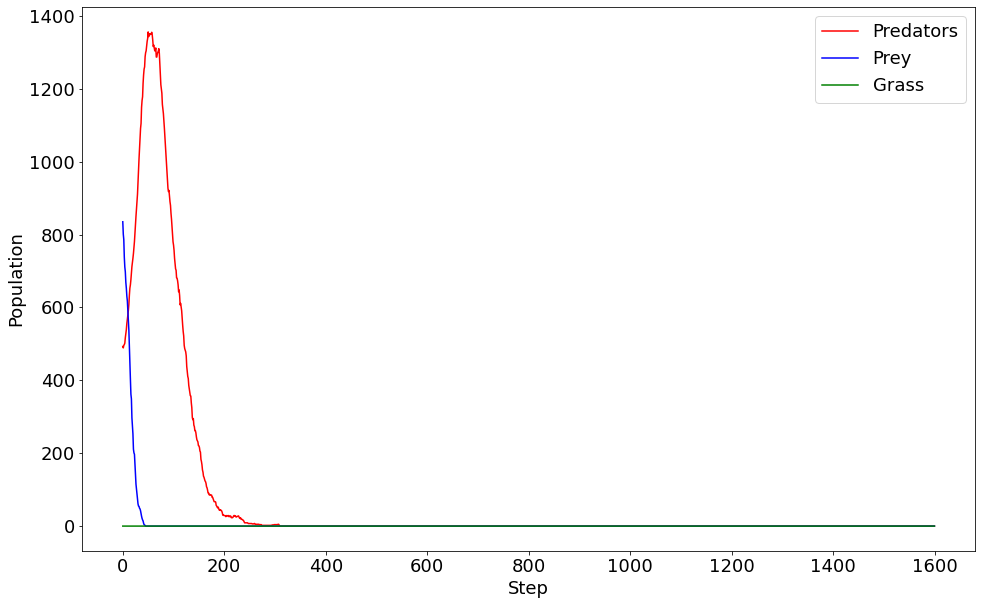

In [18]:
def run_simulation():
    """
      Execution
    """
    # Initialise the simulation
    [cudaSimulation, pop_tracker] = initialise_simulation(num_prey = 2000, num_predators = 50, num_grass = 0, seed = 64)
    cudaSimulation.SimulationConfig().steps = 1600

    # Run the simulation
    pop_tracker.reset()
    cudaSimulation.simulate()
    pop_tracker.plot()

run_simulation()

# Exercises

Note; clicking on a cell and then clicking on the blue vertical line that appears to the left, hides a cell's contents

## Exercise 1 - Checking everything runs

Run all the cells in this notebook using the "Run/Run all cells" options, to check everything's working. you should see a graph appear below showing the change in populations of prey and predators. 


## Exercise 2 - Changing the Model's Behaviour


Let's change the parameters of the model. What we're aiming for is a stable but oscillating population. Start by finding the GAIN_FROM_FOOD_PREDATOR environment variable and see how that changes the model.

Now alter the initial populations which are passed to the initialise_simulation function in the section "Set the number of steps and run!"

Check the population then oscillates. when you've got that working put the values in the cell below.


In [ ]:
#InitialPredatorPopulation=
#InitialPreyPopulation=

## Exercise 3 - Extending the Model

Now we're going to add a third agent, grass, which the prey can eat. This is going to give you an idea of how agents are created in FLAMEGPU2.

This requires changes to the model, namely

+ Prey's energy drops by 1 unit every move.
+ Prey's energy increases when it eats grass.
+ Prey dies if its energy reaches zero. No, it can't stop moving and live indefinitely!
+ Grass regrows after a certain number of iterations.

This means adding fourth and fifth message types as the grass can only be eaten by prey which are nearby. Grazing works as following.
+ Grass agents that aren't in a period of regrowth find the location of the nearest prey from the location messages.
+ If that prey is within minimum distance, a grass_eaten_message is output. All of the benefit from grass goes to the nearest prey regardless of how many prey are within range.
+ Grass agents modify the active agent variable to indicate they are in a regrowth stage. They cannot be eaten in this stage.
+ Prey agents read the grass_eaten_message messages to see if any match their ID. If so, they increase their energy.
+ Prey agents die if they do not have enough energy.

So let's add this to the model.




### Exercise 3.1 

Add the grass agent definition
+ Add a new agent type called grass
+ Add the following variables to the grass agent

| Type | Name |
| :--- | :--- |
| float | x |
| float | y |
| int | dead_cycles |
| int | available |
| float | type |

### Exercise 3.2

Create the message types for the grass agent.

**1.)** Add a message type called ``grass_location_message`` with the following properties:

| Type | Name |
| :--- | :--- |
| ID | id |
| float | x |
| float | y |

### Exercise 3.3 

Add the following functions to the grass agent, with the properties given below:

| Name | Message Input | Message Output | Message Output Optional | Allow Agent Death |
| :--- | :--- | :--- | :--- | :--- | 
| grass_output_location | n/a | grass_location_message | True | n/a |
| grass_eaten | prey_location_message | grass_eaten_message | True | True |
| grass_growth | n/a | n/a | n/a | n/a |

### Exercise 3.4

Exercise 3.4 will add a grass population to the simulation. Using the ``predatorPopulation`` and ``preyPopulation`` as examples, create a ``grassPopulation`` with variables initialised with the following properties:

| Variable | Initial Value |
| :--- | :--- |
| ``x`` | ``random.uniform(-1.0, 1.0)`` |
| ``y`` | ``random.uniform(-1.0, 1.0)`` |
| ``dead_cycles`` | ``0`` |
| ``available`` | ``1`` |
| ``type`` | ``2.0`` |


### Exercise 3.5

Include the newly created grass agent functions in the execution layers. 

**a)** Add the ``grass_output_location`` function to the layer with ``prey_output_location`` and ``predator_output_location``.
**b)** Add the ``grass_eaten`` function to the layer with ``prey_eaten``.
**c)** Add the ``grass_growth`` function to the layer with ``predator_reproduction`` and ``prey_reproduction``.
**d)** Uncomment the line ``#layer.addAgentFunction("prey", "prey_eat_or_starve")`` in ``define_execution_order`` and the lines 
  ```
  #fn = agent.newRTCFunction("prey_eat_or_starve", prey_eat_or_starve)
  #fn.setMessageInput("grass_eaten_message")
  #fn.setAllowAgentDeath(True)
  ``` 
  in ``define_agents``.


### Exercise 3.6

Next you will add the behaviour definition for the ``grass_output_location`` function. Place this below the comment "Place your code for Exercise 3.6 (grass_output_location) after here". The function should get the ``id``, ``x`` and ``y`` variables of the agent and use them to set the ``id``, ``x`` and ``y`` variables of the output message. The other grass agent function behaviour definitions have been provided for you, so if you change the initial number of grass and run the model, you should now see the grass population changing and affecting the dynamics of the simulation!

Change the values until you get a periodic solution. Place the initial values for a periodic solution in the cell below


 

In [ ]:
#prey_initial_population=
#predator_initial_population=
#grass_initial_population=

## Exercise 4

Add an extra plotting routine using matplotlib so instead of plotting the populations against time, plot the prey population against the predator population.


## Execises up this point will only be marked if received by 5pm on the 20th June. Answer to the following questions can either be answered in the session or submitted Wednesday morning.

## Exercise 5

The planet we're trying to terraform has seasons. We're assuming that we're at temperate latitudes in the Northern hemisphere and that the orbit of the planet is 12 timesteps. A quarter of the year is winter, and grass doens't grow. The grass should start growing again from where it left off in Spring

Explain in the cell below how you would implement this in words, supported by code examples if it makes your explanation clearer.



## Execise 6

Explain how you would introduce a new agent, Water source. This doesn't move, and both prey and predator require it, or they will die. Describe the initial conditions, the messages required and other features this would require. Add code exmaples if that helps.

For bonus marks apply seasonality to the water source. This is deliberately light on detail, any well justified assumptions will receive credit.

## Execise 7

It is possible to speed up this calculation by changing BruteForce messaging to Spatial2D messaging, where instead of every message being sent to every other agent which is O(N<sup>2</sup>), messages are only sent to agents within a certain radius of the agent emitting the message. This reduces communication considerably, speeding up the code.

What problem do you anticipate changing this code to use Spatial2D messaging?

How could you change the numeric constants to ameliorate this?

Put the answers in the cell below


## Great work, we can now complete our mission to terraform other worlds!